In [1]:
import numpy as np 
from tqdm import tqdm 
import pandas as pd
import itertools
from xlnet_plabel_utils import GWSDatasetFromPandas 
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots    
from permetrics.regression import RegressionMetric
from itables import show, init_notebook_mode
import marsilea as ma
import matplotlib

/nfs_home/nallapar/miniconda3/envs/dlbind/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# global variables
id_to_codon = {idx:''.join(el) for idx, el in enumerate(itertools.product(['A', 'T', 'C', 'G'], repeat=3))}
codon_to_id = {v:k for k,v in id_to_codon.items()}

stop_codons = ['TAA', 'TAG', 'TGA']

codonid_list = []

for i in range(64):
    codon = id_to_codon[i]
    if codon not in stop_codons:
        codonid_list.append(i)

print('Number of codons:', len(codonid_list))

condition_dict_values = {64: 'CTRL', 65: 'ILE', 66: 'LEU', 67: 'LEU_ILE', 68: 'LEU_ILE_VAL', 69: 'VAL'}
condition_dict = {v: k for k, v in condition_dict_values.items()}

Number of codons: 61


In [3]:
mutations_everything = np.load('bms/motifswAF_remStall_1000.npz', allow_pickle=True)

In [4]:
mutations_everything = mutations_everything['mutations_everything'].item()

In [5]:
keys = list(mutations_everything.keys())
print(keys)

[('ENSMUSG00000022751.9', 'ENSMUST00000023432.9', 122, '[63  0  5 11 21 32 48 25  0  8 23 14 41 61 49 13 22 26  8 21 49]', 'CTRL', 1.1074998378753662), ('ENSMUSG00000026535.9', 'ENSMUST00000000266.8', 147, '[ 1  5  6 12 13 56  0 48  9 37  3  6 25  0  5  0 48 37 49 25 60]', 'CTRL', 0.3945741355419159), ('ENSMUSG00000031349.4', 'ENSMUST00000033715.4', 82, '[40 57 38  0 61 52 14  8 53 22 34 30 59 26 41 43 43 18 13  2  2]', 'CTRL', 0.06217113137245178), ('ENSMUSG00000091387.2', 'ENSMUST00000171324.2', 421, '[23  7  0 29 39 56 48  0 37 48 51 32 35 12  3 23  5 57 23 25 24]', 'CTRL', 0.5394681692123413), ('ENSMUSG00000025236.11', 'ENSMUST00000217570.1', 226, '[58  2 46 22  6 22 25 34 50 38 26  2 63 58  7  1  7 39 51 55 21]', 'CTRL', 0.09662813693284988), ('ENSMUSG00000027459.16', 'ENSMUST00000109865.7', 198, '[15 56 56 58 49 37 51 46 21 21  2 22 29 62 39 50 40 51 48 59 44]', 'CTRL', 0.2214183211326599), ('ENSMUSG00000020523.14', 'ENSMUST00000108850.1', 108, '[ 5 51  3 56 51  9 25 37 63  5 41 

In [6]:
for key in keys:
    assert len(mutations_everything[key]) == 155

In [7]:
motif_str = []
motif_len = []
condition = []
perc_increase = []
orig_density_list = []
new_density_list = []

In [8]:
for k in tqdm(keys):
    # print(k)
    start = k[2]
    orig_density = k[5]
    # print(mutations_everything[k])
    for mo in mutations_everything[k]:
        # print(mo, len(mo))
        condition.append(k[4])
        new_density = mutations_everything[k][mo]
        orig_density_list.append(orig_density)
        new_density_list.append(new_density)
        # print(orig_density, new_density, (new_density-orig_density)/orig_density)
        try:
            perc_increase.append(np.abs((new_density-orig_density)/orig_density))
        except:
            perc_increase.append(0)
        # print(orig_density, new_density)
        motif_len.append(int(len(mo)/2))
        motif_sample_dict = {}
        for i in range(0, len(mo), 2):
            # print(start-mo[i], mo[i+1])
            motif_sample_dict[mo[i] - (start+10)] = mo[i+1]
        # sort the dictionary in ascending order of the keys
        motif_sample_dict = dict(sorted(motif_sample_dict.items()))
        motif_str_sample = ''
        # print(motif_sample_dict)
        for k1, v1 in motif_sample_dict.items():
            motif_str_sample += str(k1) + '_' + str(v1) + '_'
        # print(motif_str_sample)
        motif_str.append(motif_str_sample)

100%|██████████| 6000/6000 [00:07<00:00, 848.70it/s]


In [9]:
# make a dataframe
df = pd.DataFrame({'motif': motif_str, 'motif_len': motif_len, 'perc_increase': perc_increase, 'condition': condition, 'orig_density': orig_density_list, 'new_density': new_density_list})

In [10]:
pos = []
for i in range(len(motif_str)):
    x = motif_str[i].split('_')[:-1]
    x = [int(el) for el in x]
    for j in range(0, len(x), 2):
        pos.append(x[j])

In [11]:
np.unique(pos)

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

In [12]:
# condition wise get the unique motifs and get their percentage counts 
condition_wise_dfs = {}

for c in df['condition'].unique():
    df_c = df[df['condition'] == c]

    # retain only one row per unique motif
    df_c = df_c['motif'].value_counts(normalize=True).reset_index()
    df_c.columns = ['motif', 'perc']

    c_list_fin = [[] for _ in range(21)]

    for m in tqdm(df_c['motif']):
        m_s = m.split('_')[:-1]
        for i in range(0, len(m_s), 2):
            # print(id_to_codon[int(m_s[i+1])], int(m_s[i])+10)
            c_list_fin[int(m_s[i])+10].append(id_to_codon[int(m_s[i+1])])

        # other codons that are not in the motif, put - 
        pos_motif = [int(x) for x in m_s[::2]]
        for i in range(-10, 11):
            if i not in pos_motif:
                c_list_fin[i+10].append('-')

    # add the codons in the motif to the df
    for i in range(-10, 11):
        df_c['codon_'+str(i)] = c_list_fin[i+10]

    # rename the codon columns
    df_c.columns = ['motif', 'perc_counts'] + ['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    condition_wise_dfs[c] = df_c

100%|██████████| 114130/114130 [00:01<00:00, 112392.20it/s]


In [13]:
GC_FPATH = '/nfs_home/nallapar/final/riboclette/riboclette/models/xlnet/interpretability/data/genetic_code.csv'

/tmp/ipykernel_735051/4005638659.py:27: RuntimeWarning: invalid value encountered in scalar divide
  df_c_mat_perc[j, i] = (np.sum(codon_counts == id_to_codon[j])/num_non_dash)*100


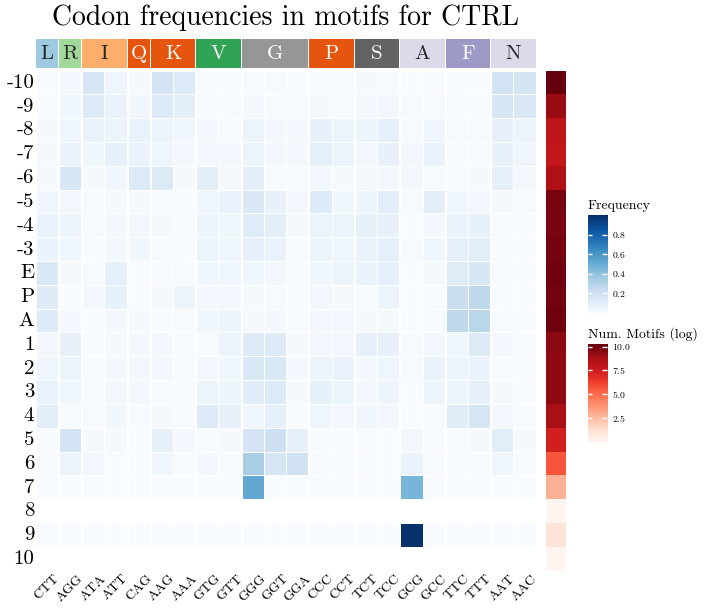

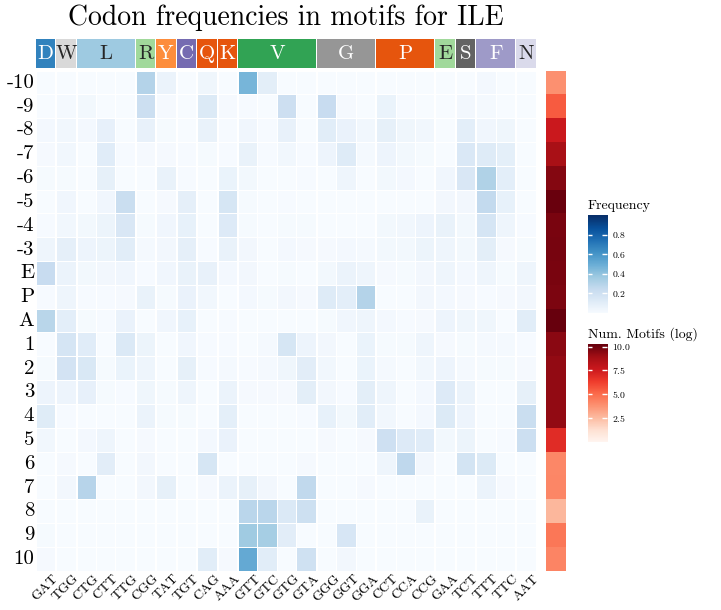

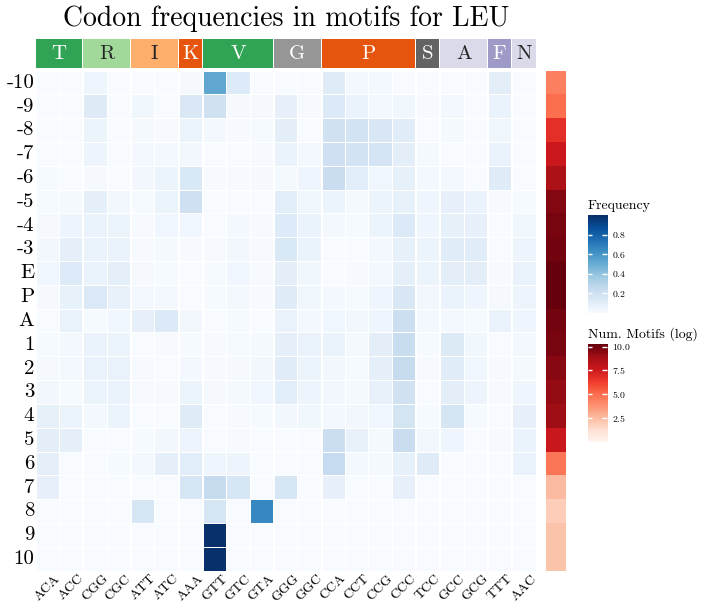

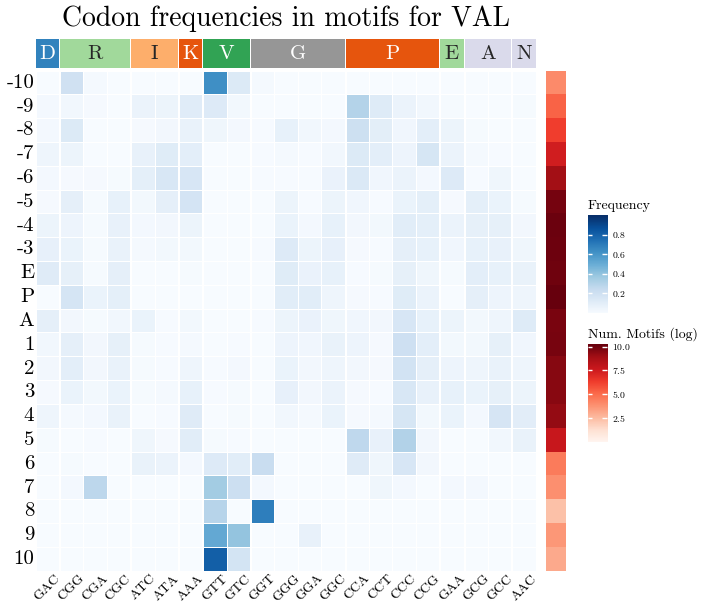

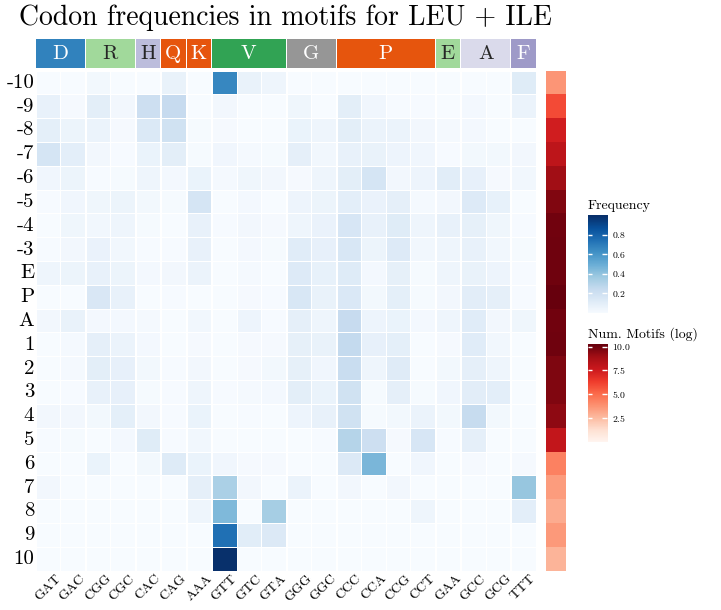

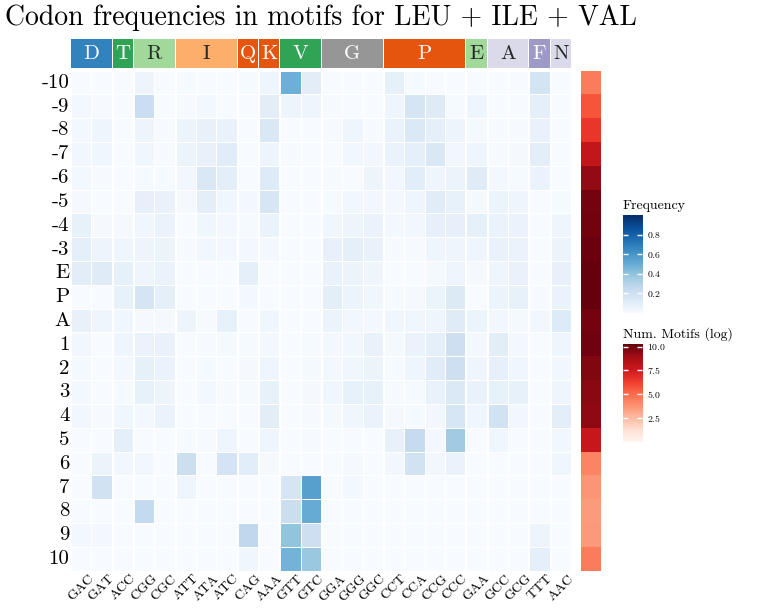

In [14]:
colors_full = plt.cm.tab20c(np.linspace(0, 1, 64))
colors_aa = np.array(colors_full).repeat(2,0)
np.random.seed(42)
np.random.shuffle(colors_aa)
max_motif_val = 28383

with plt.style.context(['science','nature','grid','bright','no-latex']):
    # for c in df['condition'].unique():
    for c in ['CTRL', 'ILE', 'LEU', 'VAL', 'LEU_ILE', 'LEU_ILE_VAL']:
        AA = ['Val', 'Ile', 'Leu', 'Lys', 'Asn', 'Thr', 'Arg', 'Ser', 'Met', 'Gln', 'His', 'Pro', 'Glu', 'Asp', 'Ala', 'Gly', 'Tyr', 'Cys', 'Trp', 'Phe', 'Stp']
        AA_1 = ['V', 'I', 'L', 'K', 'N', 'T', 'R', 'S', 'M', 'Q', 'H', 'P', 'E', 'D', 'A', 'G', 'Y', 'C', 'W', 'F', 'S']
        aa_3_1 = {AA[i]: AA_1[i] for i in range(len(AA))}

        # for c in df['condition'].unique():
        df_c = condition_wise_dfs[c]
        df_c = df_c.drop(columns=['motif', 'perc_counts'])
        df_c_mat = df_c.to_numpy()

        # convert this matrix into a percentage occurrence matrix without the '-' codon
        df_c_mat_perc = np.zeros((64, 21))
        for i in range(21):
            # get the percentage counts of the 64 codons at this position
            codon_counts = df_c_mat[:, i]
            num_non_dash = np.sum(codon_counts != '-')
            # get counts for each codon
            for j in range(64):
                df_c_mat_perc[j, i] = (np.sum(codon_counts == id_to_codon[j])/num_non_dash)*100

        # replace nans with 0
        df_c_mat_perc = np.nan_to_num(df_c_mat_perc)

        stack_data = pd.DataFrame(df_c_mat_perc, index=[id_to_codon[i] for i in range(64)])

        # sort the data by rows 
        stack_data = stack_data.sort_values(by=stack_data.columns.tolist(), ascending=False)
        # make a heatmap
        # remove rows that have a sum less than the mean of the row sums
        stack_data_t = stack_data[stack_data.sum(axis=1) > stack_data.sum(axis=1).mean()]

        # normalize every column
        stack_data_thresh = stack_data_t/stack_data_t.sum(axis=0)
        h = ma.Heatmap(stack_data_thresh.T, linewidth=0.5, width=5, height=5, cmap='Blues', label='Frequency', vmin=0, vmax=1)
        # add lables to x and y axis with chunk
        colors_set = [colors_full[codon_to_id[i]] for i in list(stack_data_thresh.index)]
        # only keep the amino acids for the codons
        genetic_code = pd.read_csv(GC_FPATH, index_col=0).set_index('Codon')
        # add one letter amino acid code to the genetic code
        genetic_code['AminoAcid_1'] = [aa_3_1[i] for i in genetic_code['AminoAcid']]
        genetic_code = genetic_code.loc[stack_data_thresh.index]
        # h.add_top(ma.plotter.Chunk(list(stack_data_thresh.index), colors_set, fontsize=15), pad=0.025)
        # group the amino acids
        h.group_cols(group=genetic_code.AminoAcid_1, order=list(set(genetic_code.AminoAcid_1)), spacing=0.002)
        colors_aa_c = []
        for i in list(set(genetic_code.AminoAcid_1)): # index of the amino acid in AA
            colors_aa_c.append(colors_aa[AA_1.index(i)])
        h.add_top(ma.plotter.Chunk(list(set(genetic_code.AminoAcid_1)), colors_aa_c, fontsize=15), pad=0.025)
        h.add_bottom(ma.plotter.Labels(list(stack_data_thresh.index), fontsize=10, rotation=45), name='Codon')

        # add right barplot with the number of motifs 
        num_motifs_list = stack_data_t.sum(axis=0).values/100
        for i in range(21):
            codon_counts = df_c_mat[:, i]
            num_non_dash = np.sum(codon_counts != '-')
            num_motifs_list[i] = num_non_dash * num_motifs_list[i]

        # log the number of motifs
        num_motifs_list = np.log(num_motifs_list+1)

        # make a colormesh plot and add it to the right of the heatmap
        cm = ma.plotter.ColorMesh(num_motifs_list.reshape(1, -1), cmap='Reds', vmin=0, vmax=np.log(max_motif_val), label='Num. Motifs (log)', label_props={'color': 'white', 'fontsize': 0})
        h.add_right(cm, pad=0.1, size=0.2)

        # h.add_right(ma.plotter.Numbers(num_motifs_list, label='Num. Motifs', show_value = True), pad=0.1)

        c_text = c 
        if c == 'LEU_ILE':
            c_text = 'LEU + ILE'
        if c == 'LEU_ILE_VAL':
            c_text = 'LEU + ILE + VAL'
        h.add_title('Codon frequencies in motifs for ' + c_text, fontsize=20, pad=0.1)

        pos_labels_list = ['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

        h.add_left(ma.plotter.Labels(list(pos_labels_list), fontsize=15))
        h.add_legends(pad=0.025)
        h.render()

        plt.savefig('bms/plots/motifswAF_remStall_1000_HeatMap_' + c + '.pdf', dpi=400, transparent=True)
        plt.show()

In [15]:
# generate peak windows, and all windows
# convert pandas dataframes into torch datasets
test_dataset = pd.read_csv('../../../data/orig/test_0.3_NZ_20_PercNan_0.05.csv')
train_dataset = pd.read_csv('../../../data/orig/train_0.3_NZ_20_PercNan_0.05.csv')
val_dataset = pd.read_csv('../../../data/orig/val_0.3_NZ_20_PercNan_0.05.csv')

# merge the datasets
merged_dataset = pd.concat([train_dataset, val_dataset, test_dataset], ignore_index=True)

# create the datasets
merged_dataset = GWSDatasetFromPandas(merged_dataset)
val_dataset = GWSDatasetFromPandas(val_dataset)

print("samples in merged dataset: ", len(merged_dataset))

samples in merged dataset:  22149


In [16]:
motifs_final_dfs = {}
motifs_final = {}
num_motifs_choose = 10
for c in df['condition'].unique():
    # put them in descending order
    df_1 = df[(df['motif_len'] == 1) & (df['condition'] == c)]['motif'].value_counts().sort_values(ascending=False)[:num_motifs_choose]
    df_2 = df[(df['motif_len'] == 2) & (df['condition'] == c)]['motif'].value_counts().sort_values(ascending=False)[:num_motifs_choose]
    df_3 = df[(df['motif_len'] == 3) & (df['condition'] == c)]['motif'].value_counts().sort_values(ascending=False)[:num_motifs_choose]

    motifs_final_dfs[c] = {'1': df_1, '2': df_2, '3': df_3}
    motifs_final[c] = df_1.index.tolist() + df_2.index.tolist() + df_3.index.tolist()
    # convert to dict with two counts for each motif
    motifs_final[c] = {m: (0, 0) for m in motifs_final[c]} # peaks, all (counts)

In [17]:
def motifCheck(motif, window):
    motif = [int(x) for x in motif.split('_')[:-1]]
    
    # print(motif_len, motif, window)
    for b in range(0, len(motif), 2):
        if window[motif[b]+10] != motif[b+1]:
            # print('False')
            return False
    # print('True')
    return True

In [18]:
window_size = 21
num_peaks_windows = 0
num_all_windows = 0

for i in tqdm(range(len(merged_dataset))):
    
    y_true_sample = merged_dataset[i][1].numpy()
    
    if len(y_true_sample) > 500:
        continue 
    x_input_sample = merged_dataset[i][0].numpy()
    sample_condition = condition_dict_values[merged_dataset[i][0][0].item()]
    nonpeak_thresh = np.nanmean(y_true_sample) - np.nanstd(y_true_sample)
    for j in range(len(y_true_sample)-window_size):
        window = x_input_sample[j:j+window_size]
        if len(window) == window_size:
            if y_true_sample[j+10] < nonpeak_thresh:
                num_peaks_windows += 1
                num_all_windows += 1
                for m in motifs_final[sample_condition]:
                    if motifCheck(m, window):
                        motifs_final[sample_condition][m] = (motifs_final[sample_condition][m][0]+1, motifs_final[sample_condition][m][1]+1)
            else:
                num_all_windows += 1
                for m in motifs_final[sample_condition]:
                    if motifCheck(m, window):
                        motifs_final[sample_condition][m] = (motifs_final[sample_condition][m][0], motifs_final[sample_condition][m][1]+1)

100%|██████████| 22149/22149 [07:46<00:00, 47.52it/s]


In [19]:
motifs_final_p = {'CTRL': {}, 'ILE': {}, 'LEU': {}, 'LEU_ILE': {}, 'LEU_ILE_VAL': {}, 'VAL': {}}
for c in motifs_final:
    for m in motifs_final[c]:
        try:
            obs = np.array([[motifs_final[c][m][0], num_peaks_windows-motifs_final[c][m][0]], [motifs_final[c][m][1], num_all_windows-motifs_final[c][m][1]-motifs_final[c][m][0]]]) ## CHANGE THIS PROPERLY
            chi2, p, dof, expected = chi2_contingency(obs, correction=True)
        except:
            if motifs_final[c][m][1] == 0:
                p = '-'
        
        motifs_final_p[c][m] = (motifs_final[c][m][0], motifs_final[c][m][1], p)

# # save motifs_final_p
# np.savez('bms/motifswAF_addStall_1000_10m.npz', motifs_final_p=motifs_final_p)

# motifs_final_p = np.load('bms/motifswAF_addStall_1000_10m.npz', allow_pickle=True)['motifs_final_p'].item()

In [20]:
def getPercIncrease(motif, condition):
    # print(motif, condition)
    x = df[(df['motif'] == motif) & (df['condition'] == condition)]['perc_increase']
    if len(x) == 0:
        return 0
    else:
        # return the mean value
        return x.mean()
    
def getFreqPerc(motif, condition):
    x = df[(df['motif'] == motif) & (df['condition'] == condition)]
    motif_len = len(motif.split('_')) // 2
    x_len = df[(df['motif_len'] == motif_len) & (df['condition'] == condition)]
    return (len(x) / len(x_len))

def getMAAPE(motif, condition):
    orig_density_lis = list(df[(df['motif'] == motif) & (df['condition'] == condition)]['orig_density'])
    new_density_lis = list(df[(df['motif'] == motif) & (df['condition'] == condition)]['new_density'])

    evaluator = RegressionMetric(new_density_lis, orig_density_lis) 
    return np.abs(evaluator.mean_arctangent_absolute_percentage_error()) * 100

/nfs_home/nallapar/miniconda3/envs/dlbind/lib/python3.9/site-packages/permetrics/regression.py:376: RuntimeWarning: divide by zero encountered in divide
  result = np.mean(np.arctan(np.abs((y_true - y_pred) / y_true)), axis=0)


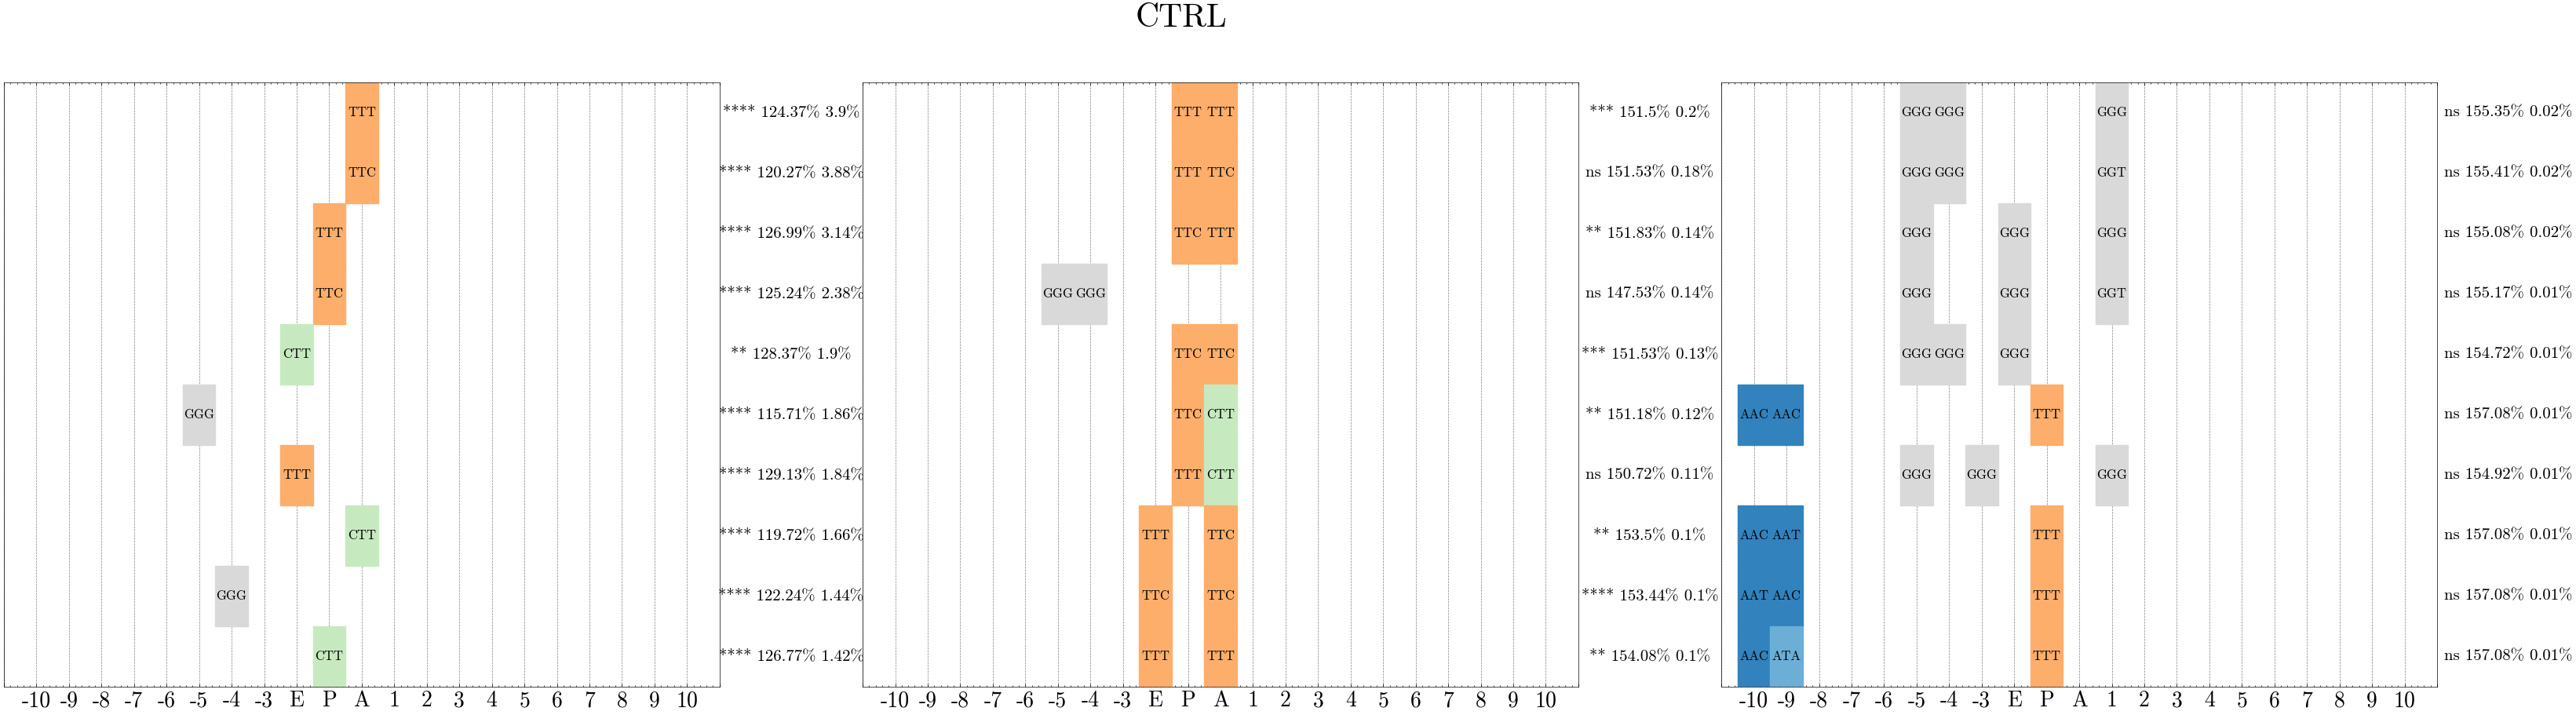

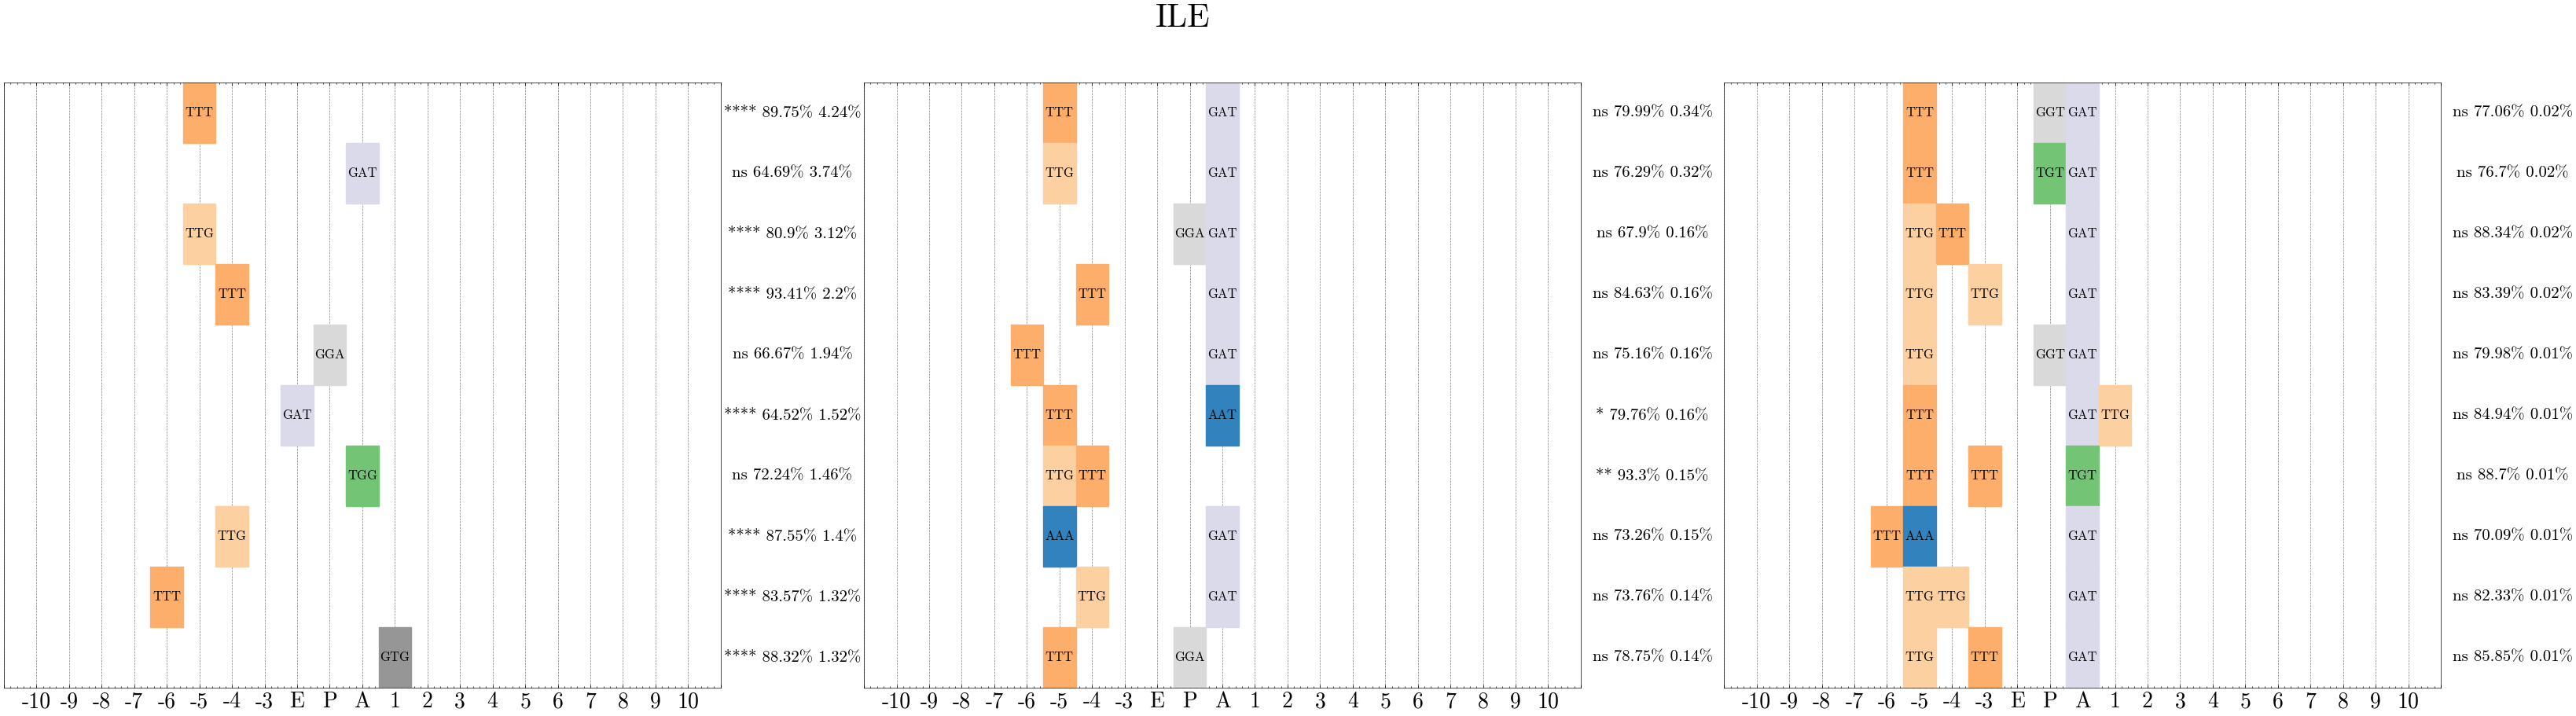

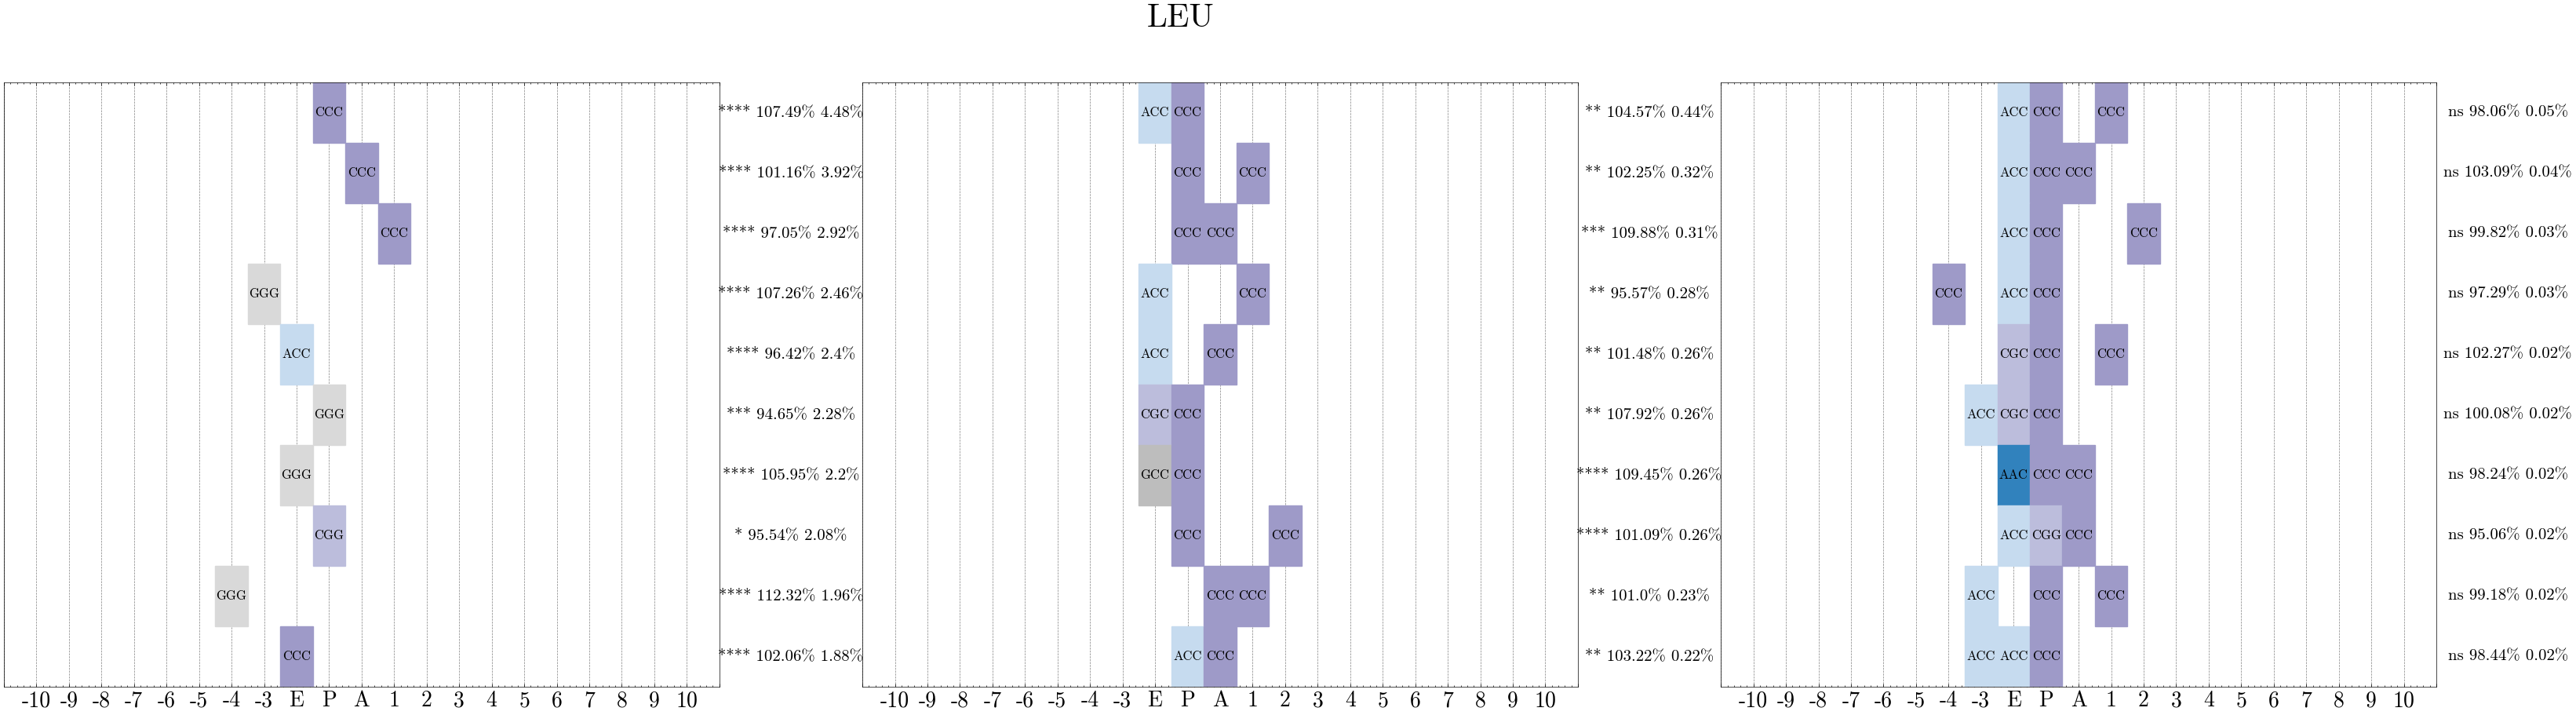

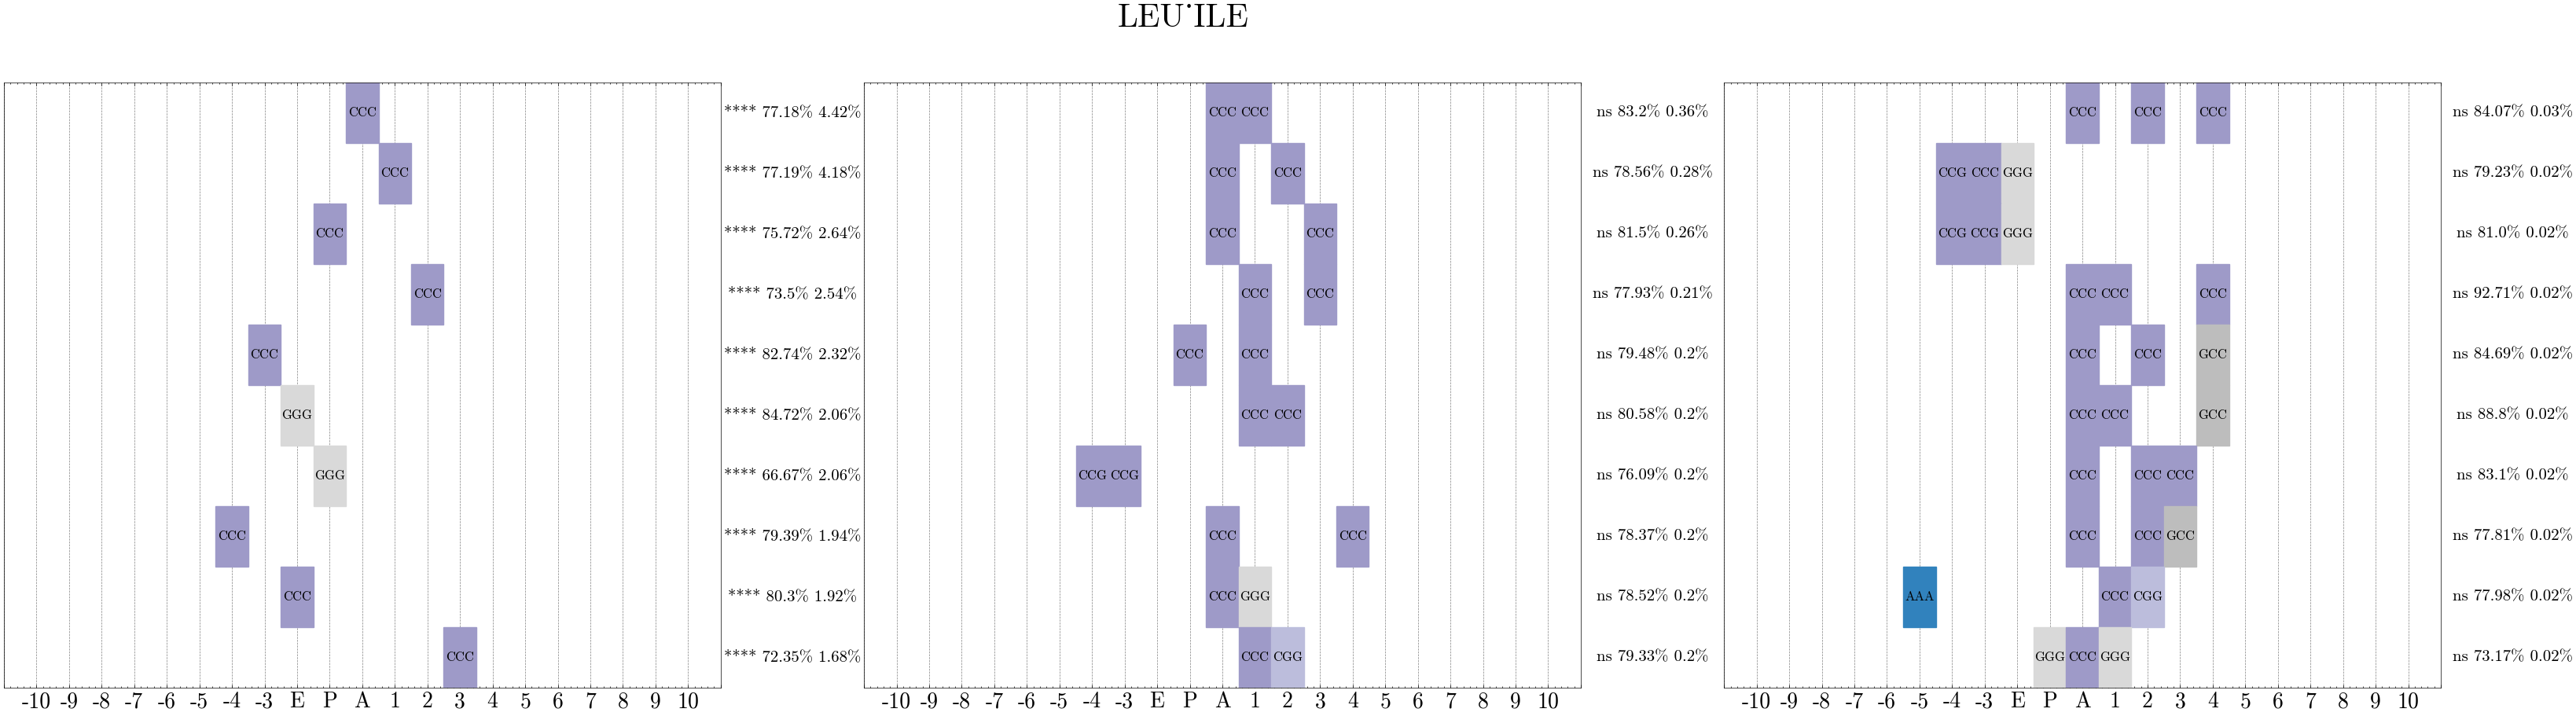

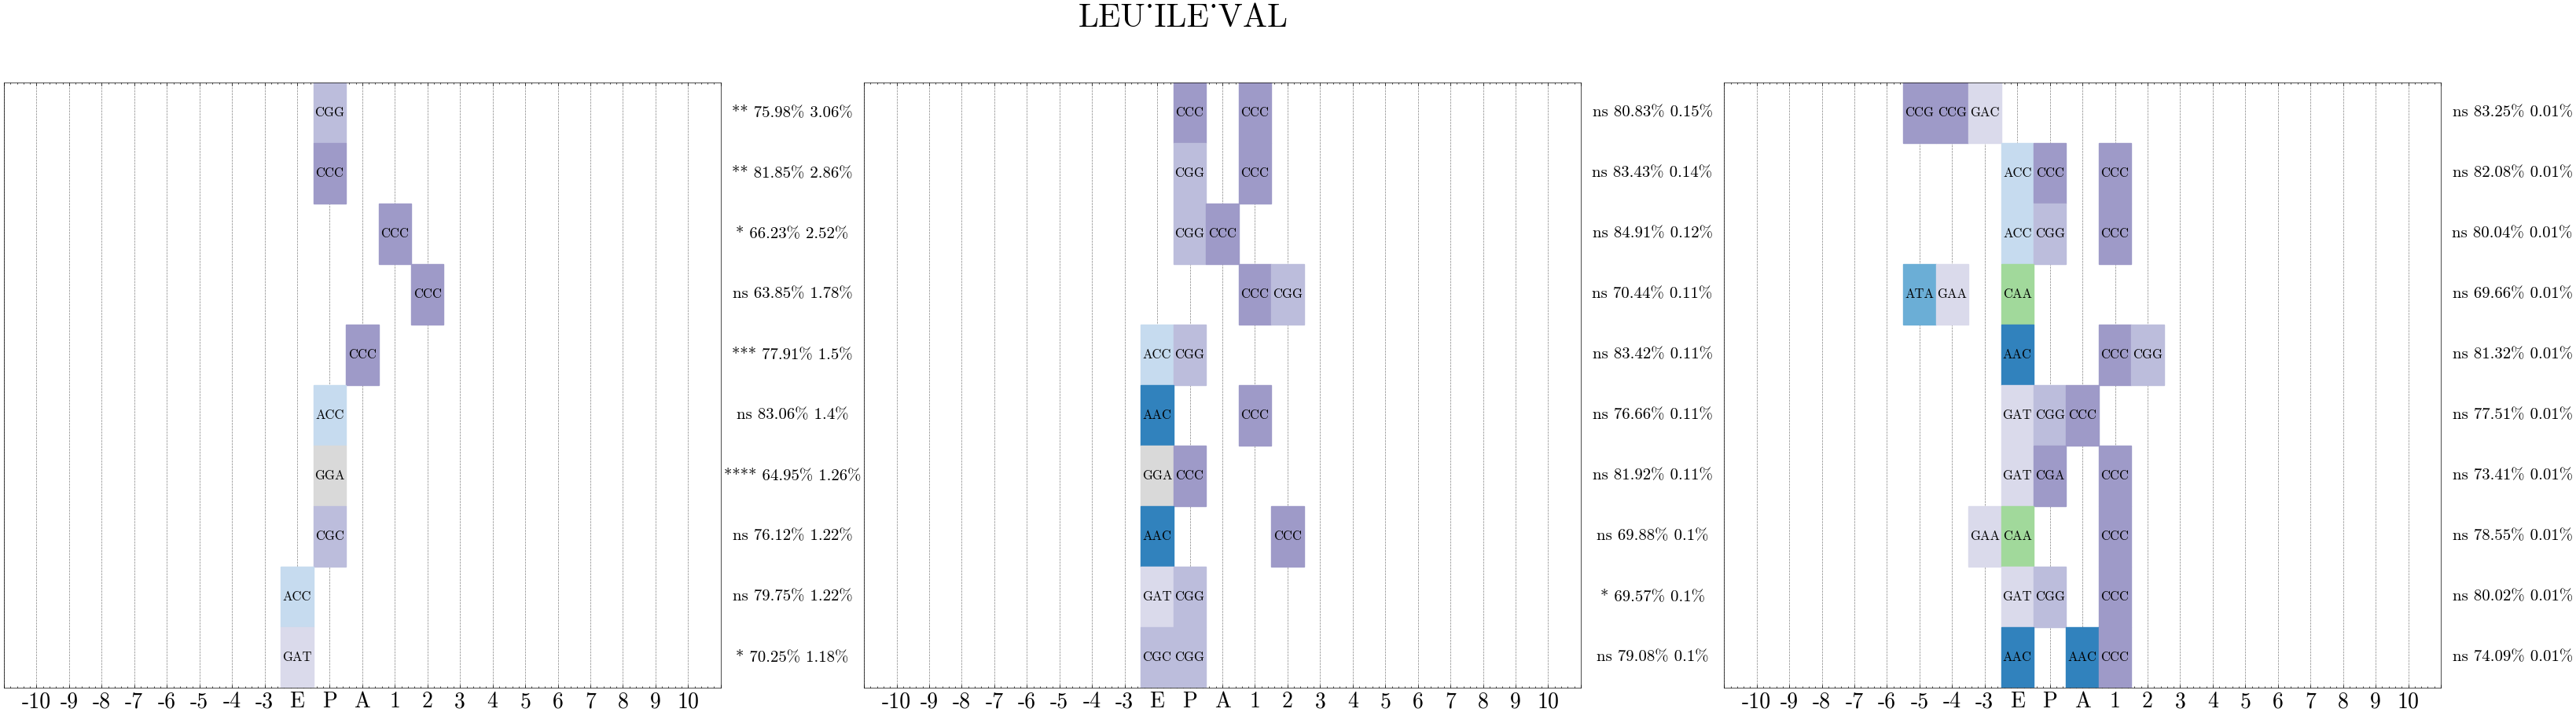

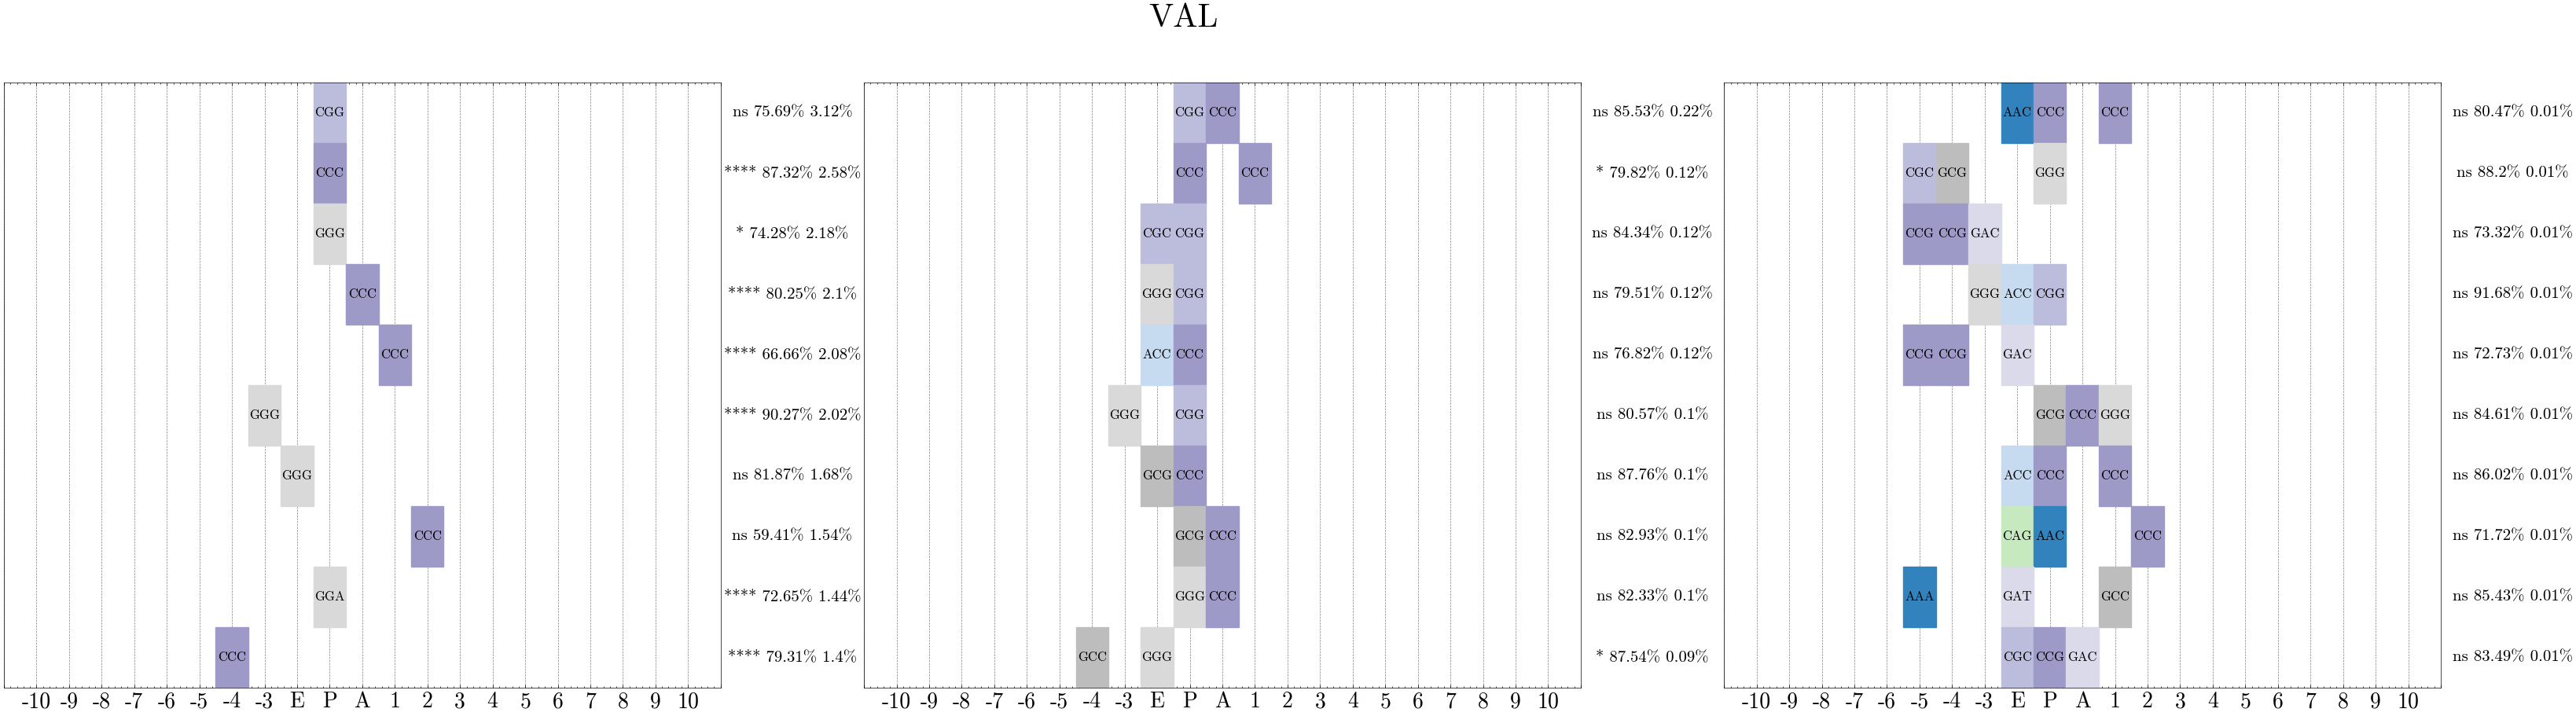

In [21]:
# gte 61 colors for the motifs
colors = plt.cm.tab20c(np.linspace(0, 1, 64))

with plt.style.context(['science','nature','grid','bright','no-latex']):
    # for c in motifs_final_p:
    for c in ['CTRL', 'ILE', 'LEU', 'LEU_ILE', 'LEU_ILE_VAL', 'VAL']:
        # make three subplots   
        fig, axs = plt.subplots(1, 3, figsize=(40, 10))
        # set the title
        fig.suptitle(c, fontsize=30)
        # for each subplot plot the 10 motifs 
        for plot in range(3):
            axs[plot].set_yticks([])
            # set x ticks
            axs[plot].set_xticks(range(-11, 12))
            axs[plot].set_xticklabels(['', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''], fontsize=20)
            motif_start = plot*10
            motifs_plot_keys = list(motifs_final_p[c].keys())[motif_start:motif_start+10]
            y_ax = 0.95
            for i in range(len(motifs_plot_keys)):
                m = [int(x) for x in motifs_plot_keys[i].split('_')[:-1]]
                for k in range(0, len(m), 2):
                    axs[plot].text(m[k], y_ax, id_to_codon[m[k+1]], ha='center', va='center', fontsize=12, color='black')
                    axs[plot].add_patch(plt.Rectangle((m[k]-0.5, y_ax-0.05), 1, 0.1, color=colors[m[k+1]], fill=True))

                # change the y-axis position for the next motif
                y_ax -= 0.1

                # add the p-value for the motif outside the figure to the right next to the motif
                try:
                    p_value_motif = float(motifs_final_p[c][motifs_plot_keys[i]][2])
                except:
                    p_value_motif = '-'
                if p_value_motif == '-':
                    p_text = 'ns'
                elif p_value_motif >= 0.05:
                    p_text = 'ns'
                elif p_value_motif < 1e-4:
                    p_text = '****'
                elif p_value_motif < 1e-3:
                    p_text = '***'
                elif p_value_motif < 1e-2:
                    p_text = '**'
                else:
                    p_text = '*'
            
                try:
                    perc_inc_motif = str(round(getMAAPE(motifs_plot_keys[i], c), 2)) + '%'
                except:
                    perc_inc_motif = 'nan'

                # add the frequency percentage after the percentage increase
                freq_perc_motif = str(round(getFreqPerc(motifs_plot_keys[i], c)*100, 2)) + '%'

                annot_text = p_text + ' ' + perc_inc_motif + ' ' + freq_perc_motif
                axs[plot].text(13.2, y_ax+0.1, annot_text, ha='center', va='center', fontsize=15, color='black')
            
        plt.savefig('bms/plots/motifswAF_remStall_1000_HeatMap_10m_L_' + c + '.pdf', dpi=300)

        plt.show()

In [ ]:
# # gte 61 colors for the motifs
# ## 100 motifs pdf save
# colors = plt.cm.tab20c(np.linspace(0, 1, 64))

# with plt.style.context(['science','nature','grid','bright','no-latex']):
#     for c in motifs_final_p:
#         # make three subplots   
#         fig, axs = plt.subplots(1, 3, figsize=(40, 100))
#         # set the title
#         fig.suptitle(c, fontsize=30)
#         # for each subplot plot the 10 motifs 
#         for plot in range(3):
#             axs[plot].set_yticks([])
#             # set x ticks
#             axs[plot].set_xlim(-11, 6)
#             axs[plot].set_ylim(0, 250)
#             axs[plot].set_xticks(range(-11, 12))
#             axs[plot].set_xticklabels(['', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''], fontsize=20)
#             # add a red line at the 0 position
#             axs[plot].axvline(x=0, color='red', linestyle='--', linewidth=1)
#             if c == 'LEU_ILE_VAL' or c == 'VAL':
#                 if plot == 0:
#                     motif_start = 0
#                     motifs_plot_keys = list(motifs_final_p[c].keys())[motif_start:motif_start+73]
#                 else:
#                     motif_start = plot*100-27
#                     motifs_plot_keys = list(motifs_final_p[c].keys())[motif_start:motif_start+100]
#             else:
#                 motif_start = plot*100
#                 motifs_plot_keys = list(motifs_final_p[c].keys())[motif_start:motif_start+100]
#             y_ax = 238
#             for i in range(len(motifs_plot_keys)):
#                 # plot these motifs 
#                 m = [int(x) for x in motifs_plot_keys[i].split('_')[:-1]]
#                 for k in range(0, len(m), 2):
#                     axs[plot].text(m[k], y_ax+10.5, id_to_codon[m[k+1]], ha='center', va='center', fontsize=12, color='black')
#                     axs[plot].add_patch(plt.Rectangle((m[k]-0.5, y_ax+10), 1, 1.5, color=colors[m[k+1]], fill=True))

#                 # change the y-axis position for the next motif
#                 y_ax -= 2.42

#                 # add the p-value for the motif outside the figure to the right next to the motif
#                 try:
#                     p_value_motif = float(motifs_final_p[c][motifs_plot_keys[i]][2])
#                 except:
#                     p_value_motif = '-'
#                 if p_value_motif == '-':
#                     p_text = 'ns'
#                 elif p_value_motif >= 0.05:
#                     p_text = 'ns'
#                 elif p_value_motif < 1e-4:
#                     p_text = '****'
#                 elif p_value_motif < 1e-3:
#                     p_text = '***'
#                 elif p_value_motif < 1e-2:
#                     p_text = '**'
#                 else:
#                     p_text = '*'
                
#                 # add the percentage increase after the p-value
#                 try:
#                     perc_inc_motif = str(round(getMAAPE(motifs_plot_keys[i], c), 2)) + '%'
#                 except:
#                     perc_inc_motif = 'nan'

#                 # add the frequency percentage after the percentage increase
#                 freq_perc_motif = str(round(getFreqPerc(motifs_plot_keys[i], c)*100, 2)) + '%'

#                 annot_text = p_text + ' ' + perc_inc_motif + ' ' + freq_perc_motif
#                 axs[plot].text(13, y_ax+13, annot_text, ha='center', va='center', fontsize=12.5, color='black')

#         plt.savefig('bms/plots/motifs_1000_21_100m_full_' + c + '.png', dpi=300)

#         plt.show()

In [ ]:
# c_list_fin = [[] for _ in range(21)]
# # print(c_list_fin)
# p_values_fin = []
# condition_fin = []
# freq_perc_fin = []
# maape_fin = []
# motif_len_fin = []
# peak_freq_fin = []
# general_freq_fin = []

# for c in tqdm(motifs_final_p):
#     for m in tqdm(motifs_final_p[c]):
#         m_s = m.split('_')[:-1]
#         motif_len_fin.append(len(m_s)//2)
#         for i in range(0, len(m_s), 2):
#             # print(id_to_codon[int(m_s[i+1])], int(m_s[i])+10)
#             c_list_fin[int(m_s[i])+10].append(id_to_codon[int(m_s[i+1])])

#         # other codons that are not in the motif, put - 
#         pos_motif = [int(x) for x in m_s[::2]]
#         for i in range(-10, 11):
#             if i not in pos_motif:
#                 c_list_fin[i+10].append('-')
#         try:
#             p_value_motif = float(motifs_final_p[c][m][2])
#         except:
#             p_value_motif = '-'
#         if p_value_motif == '-':
#             p_text = 'ns'
#         elif p_value_motif >= 0.05:
#             p_text = 'ns'
#         elif p_value_motif < 1e-4:
#             p_text = '****'
#         elif p_value_motif < 1e-3:
#             p_text = '***'
#         elif p_value_motif < 1e-2:
#             p_text = '**'
#         else:
#             p_text = '*'

#         peak_freq_fin.append(motifs_final_p[c][m][0])
#         general_freq_fin.append(motifs_final_p[c][m][1])

#         p_values_fin.append(p_text)
#         condition_fin.append(c)
#         freq_perc_fin.append(getFreqPerc(m, c)*100)
#         try:
#             maape_fin.append(getMAAPE(m, c)*100)
#         except:
#             maape_fin.append('nan')


In [ ]:
# # make dataframe
# df_fin = pd.DataFrame({'-10': c_list_fin[0], '-9': c_list_fin[1], '-8': c_list_fin[2], '-7': c_list_fin[3], '-6': c_list_fin[4], '-5': c_list_fin[5], '-4': c_list_fin[6], '-3': c_list_fin[7], 'E': c_list_fin[8], 'P': c_list_fin[9], 'A': c_list_fin[10], '1': c_list_fin[11], '2': c_list_fin[12], '3': c_list_fin[13], '4': c_list_fin[14], '5': c_list_fin[15], '6': c_list_fin[16], '7': c_list_fin[17], '8': c_list_fin[18], '9': c_list_fin[19], '10': c_list_fin[20], 'condition': condition_fin, 'freq_perc': freq_perc_fin, 'maape': maape_fin, 'motif_len': motif_len_fin, 'peak_freq': peak_freq_fin, 'general_freq': general_freq_fin, 'p_value': p_values_fin})

In [ ]:
# df_fin.to_csv('bms/motifs_1000_21_100m_WA_full.csv', index=False)

In [ ]:
df_fin = pd.read_csv('bms/motifs_1000_21_100m_WA_full.csv')

In [ ]:
show(df_fin[(df_fin["condition"] == "CTRL")], column_filter="footer", maxBytes=0, scrollCollapse=True, paging=False, scrollY="400px")    

In [ ]:
# # make a heatmap out of the df_fin in CTRL condition
# with plt.style.context(['science','nature','grid','bright','no-latex']):
#     for c in condition_dict:
#         df_fin_ctrl = df_fin[(df_fin["condition"] == c) & (df_fin["p_value"] != "ns")].drop(columns=['condition', 'freq_perc', 'maape', 'motif_len', 'peak_freq', 'general_freq', 'p_value'])

#         colors = plt.cm.tab20c(np.linspace(0, 1, 65))
#         codon_to_id['-'] = 64
#         mat = np.array(df_fin_ctrl.applymap(lambda x: codon_to_id[x]).values)
#         # get unique values in the matrix
#         unique_vals = np.unique(mat)

#         # make a custom cmap for the heatmap using colors
#         cmap = plt.cm.colors.ListedColormap(colors)
#         # set the color for 64 to white
#         cmap.colors[64] = (0, 0, 0, 0)

#         # plot a heatmap with different colors for the codons
#         fig, ax = plt.subplots(figsize=(10, 40))
#         sns.heatmap(mat, cbar=False, cmap=cmap)
#         # remove the y-axis labels
#         ax.set_yticks([])
#         ax.set_xticks(range(21))
#         ax.set_xticklabels(['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], fontsize=20)

#         # push the x ticks to the right even more
#         plt.xticks(ha='left', rotation=0)

#         # custom legend only for the codons in unique_vals
#         # remove 64 from the unique_vals
#         unique_vals = unique_vals[unique_vals != 64]
#         custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=8) for i in unique_vals]

#         plt.title(c + " HeatMap", fontsize=20)

#         # add the legend
#         plt.legend(custom_lines, [id_to_codon[i] for i in unique_vals], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
#         fig.tight_layout()
#         plt.savefig('bms/plots/heatmap_' + c + '.png', dpi=300)
#         plt.show()

#         plt.clf()

In [ ]:
# colors = plt.cm.tab20c(np.linspace(0, 1, 65))

# # make a custom cmap for the heatmap using colors
# cmap = matplotlib.colors.ListedColormap([colors[i] for i in range(65)])
# # set the color for 64 to white
# cmap.colors[64] = (0, 0, 0, 0)
# codon_to_id['-'] = 64
# id_to_codon[64] = '-'

# fig, ax = plt.subplots(2, 3, figsize=(30, 20))
# axs = ax.ravel()

# # six plots for the heatmap
# for i, c in enumerate(condition_dict):
#     df_fin_ctrl = df_fin[(df_fin["condition"] == c) & (df_fin["p_value"] != "ns")].drop(columns=['condition', 'freq_perc', 'maape', 'motif_len', 'peak_freq', 'general_freq', 'p_value'])
#     # df_fin_ctrl = df_fin[(df_fin["condition"] == c)].drop(columns=['condition', 'freq_perc', 'maape', 'motif_len', 'peak_freq', 'general_freq', 'p_value'])
#     # sort data in column P and E
#     df_fin_ctrl = df_fin_ctrl.sort_values(by=['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], ascending=False)
    
#     data = np.array(df_fin_ctrl.applymap(lambda x: codon_to_id[x]).values)

#     # add padding to data 
#     pad_arr = [64]*21
#     data = np.vstack([pad_arr, pad_arr, pad_arr, pad_arr, pad_arr, data])

#     unique_vals = np.unique(data)

#     # h = ma.Heatmap(data, linewidth=0.001, cmap=cmap)
#     # make the colomesh with padding 
#     h = ma.plotter.ColorMesh(data, cmap=cmap, linewidth=0.001)
#     h.render(axs[i])

#     pos_labels = ma.plotter.Labels(['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], rotation=0, size=14)
#     pos_labels.set_side('bottom')
#     pos_labels.render(axs[i])

#     # h.add_top(ma.plotter.Labels(["-10", "-9", "-8", "-7", "-6", "-5", "-4", "-3", "E", "P", "A", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], rotation=0, size=10))
#     # h.add_legends()
#     if c == 'CTRL':
#         c_text = 'Control'
#     elif c == 'ILE':
#         c_text = 'Isoleucine'
#     elif c == 'LEU':
#         c_text = 'Leucine'
#     elif c == 'LEU_ILE':
#         c_text = 'Leucine + Isoleucine'
#     elif c == 'LEU_ILE_VAL':
#         c_text = 'Leucine + Isoleucine + Valine'
#     elif c == 'VAL':
#         c_text = 'Valine'
#     axs[i].set_title(c_text + " Motifs", fontsize=20)

#     # plt.savefig('bms/plots/heatmap_' + c + '.png', dpi=300)
#     # plt.show()

# # add a legend for the codons
# custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=8) for i in range(64)]

# # add a bounding box for the legend
# plt.legend(custom_lines, [id_to_codon[i] for i in range(64)], loc='center left', bbox_to_anchor=(1.2, 1), fontsize=20, ncol=4, title='Codons', title_fontsize=15)
# plt.axis('off')

# plt.tight_layout()
 
# plt.savefig('bms/plots/heatmap_motifs.pdf', dpi=300)
# plt.show()